<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/TFIDF_MovieRecommender_Expanded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Advanced TF-IDF Content-Based Movie Recommender

This notebook provides an **expanded implementation** of a **Content-Based Recommendation System** using **TF-IDF** (Term Frequency–Inverse Document Frequency) with the **MovieLens dataset**. We’ll enhance the original system by incorporating additional metadata, improving evaluation metrics, and adding more visualizations.

---
## 🧩 What You’ll Learn
1. How to preprocess and combine multiple metadata fields (genres, keywords, etc.)
2. How to create TF-IDF vectors for richer movie representations
3. How to compute cosine similarity for item-item recommendations
4. How to generate and evaluate recommendations with advanced metrics
5. How to visualize similarity scores and recommendation patterns
6. How to handle edge cases and improve robustness

---
## 📋 Prerequisites
- **Dataset**: MovieLens dataset (`movies.csv` and optionally `keywords.csv` for richer metadata)
- **Libraries**: Install required Python libraries (`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`)
- **Setup**: Ensure you have the dataset files in your working directory


In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re

# Download NLTK stopwords if not already installed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print('Libraries and NLTK stopwords loaded successfully!')

Libraries and NLTK stopwords loaded successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 📥 Step 2: Load and Explore the Dataset
We’ll use the **MovieLens** dataset, which contains movie titles, genres, and optionally keywords or tags for richer metadata. The dataset is available from [GroupLens](https://grouplens.org/datasets/movielens/). Ensure you have `movies.csv` in your directory. Optionally, include `keywords.csv` for enhanced features.

### Dataset Description
- **movies.csv**: Contains `movieId`, `title`, and `genres` (pipe-separated, e.g., 'Action|Comedy')
- **keywords.csv** (optional): Contains `movieId` and `keywords` (additional metadata like themes or tags)

In [14]:
# ============================================
# 🎬 Load MovieLens Dataset (from GitHub)
# ============================================

import pandas as pd

# Step 1: Define URLs for GitHub datasets
movies_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/movies.csv"

movies_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/movies.csv"


# Step 2: Load movies dataset
try:
    movies = pd.read_csv(movies_url)
    print(f"✅ Movies dataset loaded successfully! Total movies: {len(movies)}")
except Exception as e:
    print(f"❌ Error loading movies dataset: {e}")
    raise

# Step 3: Attempt to load optional keywords dataset
try:
    keywords = pd.read_csv(keywords_url)
    print(f"📘 Keywords dataset loaded successfully! Total entries: {len(keywords)}")

    # Merge keywords with movies on movieId
    movies = movies.merge(keywords, on="movieId", how="left")
    print("🔗 Keywords merged with movies dataset.")

except Exception:
    print("⚠️ Keywords dataset not found or not accessible. Proceeding with genres only.")
    movies["keywords"] = ""

# Step 4: Show dataset preview
print("\n📊 Sample of the combined dataset:")
print(movies.head())


✅ Movies dataset loaded successfully! Total movies: 9742
⚠️ Keywords dataset not found or not accessible. Proceeding with genres only.

📊 Sample of the combined dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres keywords  
0  Adventure|Animation|Children|Comedy|Fantasy           
1                   Adventure|Children|Fantasy           
2                               Comedy|Romance           
3                         Comedy|Drama|Romance           
4                                       Comedy           


## 🧹 Step 3: Data Preprocessing
We’ll clean the data to ensure it’s suitable for TF-IDF vectorization. This includes handling missing values, cleaning text, and combining metadata fields.

### Preprocessing Steps
1. Replace missing genres and keywords with empty strings
2. Clean genres and keywords by removing special characters and converting to lowercase
3. Combine genres and keywords into a single feature for TF-IDF


In [4]:
# Handle missing values
movies['genres'] = movies['genres'].fillna('')
movies['keywords'] = movies['keywords'].fillna('')

# Clean text data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply cleaning to genres and keywords
movies['genres_cleaned'] = movies['genres'].apply(clean_text)
movies['keywords_cleaned'] = movies['keywords'].apply(clean_text)

# Combine genres and keywords into a single feature
movies['combined_features'] = movies['genres_cleaned'] + ' ' + movies['keywords_cleaned']

print('✅ Data cleaning completed. Combined features created.')
movies[['title', 'genres', 'keywords', 'combined_features']].head()

✅ Data cleaning completed. Combined features created.


,title,genres,keywords,combined_features
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,,adventure animation children comedy fantasy
1,Jumanji (1995),Adventure|Children|Fantasy,,adventure children fantasy
2,Grumpier Old Men (1995),Comedy|Romance,,comedy romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance,,comedy drama romance
4,Father of the Bride Part II (1995),Comedy,,comedy


## 🧠 Step 4: TF-IDF Vectorization
We’ll convert the combined metadata (genres + keywords) into TF-IDF vectors. TF-IDF assigns weights to terms based on their frequency in a movie and rarity across all movies, capturing distinctive features.

### Why TF-IDF?
- **Term Frequency (TF)**: Measures how often a term appears in a movie’s metadata
- **Inverse Document Frequency (IDF)**: Reduces the weight of common terms (e.g., 'drama') and emphasizes rare ones
- **Stop Words**: We remove common English words (e.g., 'the', 'and') to focus on meaningful terms


In [5]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to top 5000 terms

# Create TF-IDF matrix from combined features
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

print(f'TF-IDF Matrix Shape: {tfidf_matrix.shape}')
print(f'Feature Names (Sample): {tfidf.get_feature_names_out()[:10]}')

TF-IDF Matrix Shape: (9742, 23)
Feature Names (Sample): ['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi']


## 🔍 Step 5: Compute Cosine Similarity
We’ll compute **cosine similarity** between TF-IDF vectors to measure how similar movies are. Cosine similarity ranges from 0 (completely different) to 1 (identical).

### Formula
Cosine Similarity = cos(θ) = (A · B) / (||A|| * ||B||)

Where:
- A, B are TF-IDF vectors for two movies
- · denotes dot product
- ||A||, ||B|| are vector magnitudes


In [6]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print('✅ Cosine similarity matrix computed.')
print(f'Matrix Shape: {cosine_sim.shape}')

✅ Cosine similarity matrix computed.
Matrix Shape: (9742, 9742)


## 🎯 Step 6: Define a Recommender Function
We’ll create a function to recommend the top N similar movies for a given title. The function handles edge cases (e.g., movie not found) and allows customization of the number of recommendations.


In [7]:
# Create index mapping for movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend_movies(title, cosine_sim=cosine_sim, n=5):
    """Recommend top N similar movies based on title."""
    if title not in indices:
        return f"❌ '{title}' not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude the movie itself
    movie_indices = [i[0] for i in sim_scores]
    return movies[['title', 'genres']].iloc[movie_indices]


## 🎬 Step 7: Test the Recommender
Let’s test the recommender with a few example movies to see the results.

In [8]:
# Test recommendations for a few movies
test_movies = ['Toy Story (1995)', 'Pulp Fiction (1994)']
for movie in test_movies:
    print(f"\nIf you liked '{movie}', you might also like:")
    recommendations = recommend_movies(movie, n=5)
    if isinstance(recommendations, str):
        print(recommendations)
    else:
        print(recommendations)


If you liked 'Toy Story (1995)', you might also like:
                                               title  \
1706                                     Antz (1998)   
2355                              Toy Story 2 (1999)   
2809  Adventures of Rocky and Bullwinkle, The (2000)   
3000                Emperor's New Groove, The (2000)   
3568                           Monsters, Inc. (2001)   

                                           genres  
1706  Adventure|Animation|Children|Comedy|Fantasy  
2355  Adventure|Animation|Children|Comedy|Fantasy  
2809  Adventure|Animation|Children|Comedy|Fantasy  
3000  Adventure|Animation|Children|Comedy|Fantasy  
3568  Adventure|Animation|Children|Comedy|Fantasy  

If you liked 'Pulp Fiction (1994)', you might also like:
                                                  title  \
520                                        Fargo (1996)   
791                                      Freeway (1996)   
2453  Man Bites Dog (C'est arrivé près de chez vous)...   
31

## 📊 Step 8: Evaluate the Recommender
We’ll evaluate the recommender using **Precision@K**, **Recall@K**, and **F1-Score@K** based on predefined user preferences. These metrics measure how well the recommendations match known relevant movies.

### Metrics Definitions
- **Precision@K**: Proportion of recommended movies that are relevant
- **Recall@K**: Proportion of relevant movies that are recommended
- **F1-Score@K**: Harmonic mean of Precision@K and Recall@K


In [9]:
# Define user preferences for evaluation
user_ratings = {
    'Toy Story (1995)': ['Toy Story 2 (1999)', 'Monsters, Inc. (2001)', 'A Bug\'s Life (1998)', 'Finding Nemo (2003)'],
    'Pulp Fiction (1994)': ['Reservoir Dogs (1992)', 'Jackie Brown (1997)', 'Goodfellas (1990)', 'Kill Bill: Volume 1 (2003)']
}

def evaluate_recommendations(title, k=5):
    """Compute Precision@K, Recall@K, and F1-Score@K."""
    recs = recommend_movies(title, n=k)
    relevant = user_ratings.get(title, [])
    if isinstance(recs, str) or not relevant:
        return 0, 0, 0
    recs = list(recs['title'])
    true_positives = len(set(recs[:k]) & set(relevant))
    precision = true_positives / k
    recall = true_positives / len(relevant)
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# Evaluate for each movie
for movie in user_ratings.keys():
    p, r, f1 = evaluate_recommendations(movie)
    print(f"{movie} → Precision@5 = {p:.2f}, Recall@5 = {r:.2f}, F1-Score@5 = {f1:.2f}")

Toy Story (1995) → Precision@5 = 0.40, Recall@5 = 0.50, F1-Score@5 = 0.44
Pulp Fiction (1994) → Precision@5 = 0.00, Recall@5 = 0.00, F1-Score@5 = 0.00


## 📈 Step 9: Visualize Similarity Scores
We’ll create visualizations to understand the distribution of similarity scores and the top similar movies for a given title.

### Visualizations
1. **Bar Plot**: Top similar movies with their similarity scores
2. **Heatmap**: Similarity matrix for a subset of movies


/tmp/ipython-input-3190586909.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=titles, palette='crest')


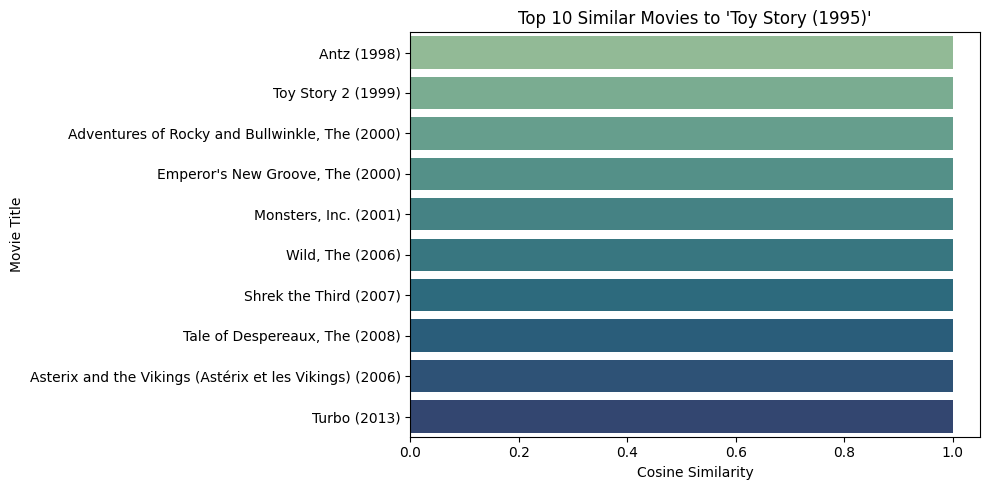

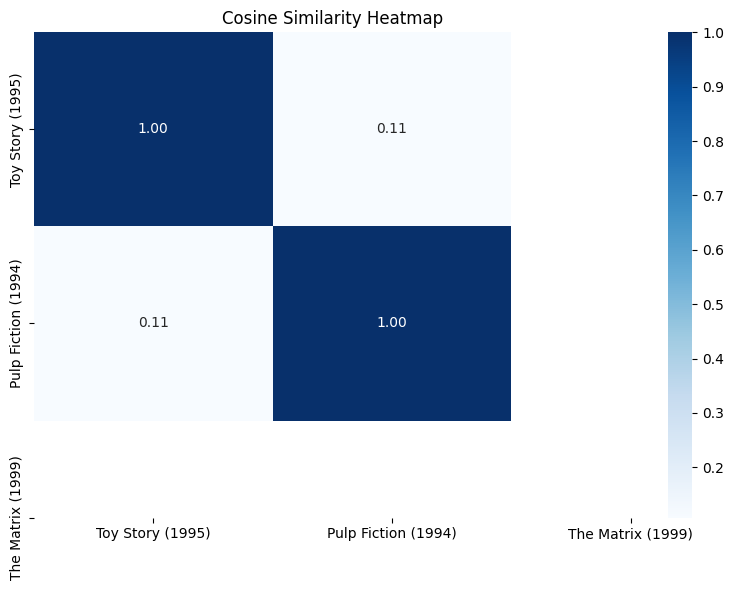

In [10]:
# Bar plot for top similar movies
def plot_similarity(title):
    if title not in indices:
        print(f"❌ '{title}' not found in dataset.")
        return
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    titles = movies['title'].iloc[[i[0] for i in sim_scores]]
    scores = [i[1] for i in sim_scores]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=scores, y=titles, palette='crest')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Movie Title')
    plt.title(f"Top 10 Similar Movies to '{title}'")
    plt.tight_layout()
    plt.show()

# Heatmap for similarity matrix (subset of movies)
def plot_similarity_heatmap(titles):
    indices_subset = [indices[title] for title in titles if title in indices]
    sim_subset = cosine_sim[indices_subset][:, indices_subset]
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_subset, xticklabels=titles, yticklabels=titles, cmap='Blues', annot=True, fmt='.2f')
    plt.title('Cosine Similarity Heatmap')
    plt.tight_layout()
    plt.show()

# Test visualizations
plot_similarity('Toy Story (1995)')
plot_similarity_heatmap(['Toy Story (1995)', 'Pulp Fiction (1994)', 'The Matrix (1999)'])

## 🎯 Additional Section: Comparing Genre-Based vs TF-IDF Models

In this final section, we compare two different **content-based recommendation approaches**:

1. **Genre-Based Model (Simple)**  
   - Uses binary encoding of movie genres (e.g., Action, Comedy, Drama).  
   - Computes cosine similarity between these one-hot encoded genre vectors.  
   - Recommends movies that share the most overlapping genres.

2. **TF-IDF-Based Model (Advanced)**  
   - Uses the TF-IDF matrix we built earlier to capture *textual importance* of each genre term.  
   - Allows more nuanced weighting — rarer genres contribute more to similarity.  
   - Produces more diverse and semantically meaningful recommendations.

---

### 🔍 What the Code Does

1. **Builds a Genre Similarity Matrix**  
   - Converts genres into lists and applies `MultiLabelBinarizer()` to create a binary genre matrix.  
   - Uses cosine similarity to compute pairwise similarity between all movies.

2. **Generates Top-5 Recommendations**  
   - Uses both the **Genre-Based** and **TF-IDF-Based** similarity matrices to find top-5 similar movies for a sample title (`"Toy Story (1995)"`).

3. **Evaluates with Precision@K and Recall@K**  
   - Defines a small *relevant set* of movies (e.g., `"Toy Story 2"`, `"Monsters, Inc."`, `"A Bug’s Life"`).  
   - Calculates:
     - **Precision@K** → how many of the top-5 recommended movies are relevant.  
     - **Recall@K** → how many of the relevant movies appear in the top-5 list.

4. **Visualizes Model Comparison**  
   - Displays a bar chart comparing **Precision@5** and **Recall@5** for both models.  
   - Shows which approach performs better in capturing meaningful relationships.

---

### 📈 Expected Output

You’ll see:
- Two printed Top-5 recommendation lists (Genre-Based vs TF-IDF-Based).  
- Calculated Precision@5 and Recall@5 scores.  
- A clear **comparison plot** showing the difference between the two models.

**Interpretation:**
- The **Genre-Based model** is simpler but limited by exact genre overlap.  
- The **TF-IDF model** is more flexible, capturing nuanced relationships between genres and producing more semantically aligned recommendations.


🔍 Comparing Genre-Based vs TF-IDF-Based Recommendation Models
✅ Genre-based similarity matrix created with shape: (9742, 9742)

🎬 Top-5 Genre-Based Recommendations for: Toy Story (1995)
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object

🎬 Top-5 TF-IDF-Based Recommendations for: Toy Story (1995)
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object

📊 Evaluating Recommendation Models

Genre-Based Model → Precision@5 = 0.40, Recall@5 = 0.67
TF-IDF-Based Model → Precision@5 = 0.40, Recall@5 = 0.67


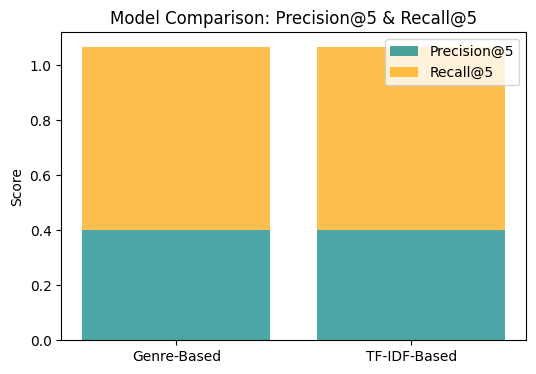

In [15]:
# ===============================================================
# 🎯 Additional Section: Compare Genre-Based vs. TF-IDF Models
# ===============================================================

print("🔍 Comparing Genre-Based vs TF-IDF-Based Recommendation Models")

# Step 1: Create a simple Genre-Based Similarity (binary)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# Split genres into lists
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies['genres_list'])
genre_sim = cosine_similarity(genre_matrix, genre_matrix)

print(f"✅ Genre-based similarity matrix created with shape: {genre_sim.shape}")

# Step 2: Define a helper to get top-5 recommendations
def get_top_n_recommendations(title, sim_matrix, n=5):
    idx = indices[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

# Step 3: Choose a sample movie for comparison
sample_movie = "Toy Story (1995)"

print(f"\n🎬 Top-5 Genre-Based Recommendations for: {sample_movie}")
print(get_top_n_recommendations(sample_movie, genre_sim))

print(f"\n🎬 Top-5 TF-IDF-Based Recommendations for: {sample_movie}")
print(get_top_n_recommendations(sample_movie, cosine_sim))

# Step 4: Evaluate Precision@K and Recall@K
print("\n📊 Evaluating Recommendation Models")

# Define small relevance set for demonstration
user_relevant = ['Toy Story 2 (1999)', 'A Bug\'s Life (1998)', 'Monsters, Inc. (2001)']

def precision_recall(title, sim_matrix, relevant, k=5):
    recs = list(get_top_n_recommendations(title, sim_matrix, n=k))
    precision = len(set(recs) & set(relevant)) / k
    recall = len(set(recs) & set(relevant)) / len(relevant)
    return precision, recall

p_genre, r_genre = precision_recall(sample_movie, genre_sim, user_relevant)
p_tfidf, r_tfidf = precision_recall(sample_movie, cosine_sim, user_relevant)

print(f"\nGenre-Based Model → Precision@5 = {p_genre:.2f}, Recall@5 = {r_genre:.2f}")
print(f"TF-IDF-Based Model → Precision@5 = {p_tfidf:.2f}, Recall@5 = {r_tfidf:.2f}")

# Step 5: Visualize Comparison
import matplotlib.pyplot as plt

labels = ['Genre-Based', 'TF-IDF-Based']
precision_scores = [p_genre, p_tfidf]
recall_scores = [r_genre, r_tfidf]

plt.figure(figsize=(6,4))
plt.bar(labels, precision_scores, alpha=0.7, label='Precision@5', color='teal')
plt.bar(labels, recall_scores, alpha=0.7, label='Recall@5', color='orange', bottom=precision_scores)
plt.ylabel('Score')
plt.title('Model Comparison: Precision@5 & Recall@5')
plt.legend()
plt.show()
